In [1]:
%reload_ext autoreload
%autoreload 2
import ast
import pickle
import itertools
from collections import Counter
from tqdm import tqdm
import pandas as pd
import os

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns 
import cv2
import swifter

import sys
sys.path.append('..')

from analysis.generate_cluster_information_file import load, extract_all_information_query, to_df_query
from common.image_processing import pixel_intensity_histogram

In [6]:
df = load()
df.head(5)

,score,background_threshold,cluster_num,cluster_sizes,cluster_peak_intensities,cluster_num_intensities,cluster_centers
id,,,,,,,
1002900,2.631728,0,50,"[144, 38, 24, 16, 5, 39, 17, 18, 26, 11, 56, 1...","[6, 6, 2, 2, 1, 8, 2, 1, 3, 1, 3, 2, 255, 2, 6...","[6, 6, 2, 2, 1, 7, 2, 1, 3, 1, 3, 2, 71, 2, 6,...","[(3, 524), (44, 425), (55, 321), (66, 400), (9..."
1003620,1.560731,0,104,"[28, 17, 8, 11, 45, 4, 14, 71, 1, 7, 2, 18, 11...","[4, 2, 1, 2, 9, 1, 2, 16, 1, 1, 1, 3, 1, 1, 1,...","[4, 2, 1, 2, 8, 1, 2, 14, 1, 1, 1, 3, 1, 1, 1,...","[(19, 375), (53, 839), (56, 524), (84, 208), (..."
1005208,3.137059,1,71,"[53, 27, 42, 6, 3, 15, 19, 45, 73, 115, 119, 6...","[12, 4, 9, 2, 2, 2, 3, 4, 9, 68, 78, 2, 2, 2, ...","[10, 3, 8, 1, 1, 1, 2, 3, 8, 31, 34, 1, 1, 1, ...","[(3, 582), (0, 715), (14, 83), (19, 614), (51,..."
1005849,3.509851,2,49,"[1, 5, 61, 4, 80, 45, 68, 44, 10, 35, 28, 7, 3...","[3, 3, 12, 3, 69, 15, 12, 17, 3, 4, 5, 3, 3, 3...","[1, 1, 10, 1, 27, 8, 9, 13, 1, 2, 3, 1, 1, 1, ...","[(0, 906), (0, 949), (5, 508), (24, 591), (34,..."
1006237,1.371129,0,169,"[3, 92, 6, 138, 16, 12, 142, 6, 31, 1, 11, 3, ...","[1, 179, 1, 255, 2, 1, 5, 1, 5, 1, 1, 1, 3, 1,...","[1, 41, 1, 47, 2, 1, 5, 1, 5, 1, 1, 1, 3, 1, 2...","[(0, 604), (2, 736), (13, 155), (26, 601), (22..."


In [7]:
# pd saves lists as strings, so we need to convert them to lists manually
df.cluster_sizes = df.cluster_sizes.swifter.apply(ast.literal_eval)
df.cluster_centers = df.cluster_centers.swifter.apply(ast.literal_eval)
df.cluster_peak_intensities = df.cluster_peak_intensities.swifter.apply(ast.literal_eval)
df.cluster_num_intensities = df.cluster_num_intensities.swifter.apply(ast.literal_eval)

assert type(df.cluster_sizes.tolist()[0]) == list

df.head(10)

,score,background_threshold,cluster_num,cluster_sizes,cluster_peak_intensities,cluster_num_intensities,cluster_centers
id,,,,,,,
1002900,2.631728,0,50,"[144, 38, 24, 16, 5, 39, 17, 18, 26, 11, 56, 1...","[6, 6, 2, 2, 1, 8, 2, 1, 3, 1, 3, 2, 255, 2, 6...","[6, 6, 2, 2, 1, 7, 2, 1, 3, 1, 3, 2, 71, 2, 6,...","[(3, 524), (44, 425), (55, 321), (66, 400), (9..."
1003620,1.560731,0,104,"[28, 17, 8, 11, 45, 4, 14, 71, 1, 7, 2, 18, 11...","[4, 2, 1, 2, 9, 1, 2, 16, 1, 1, 1, 3, 1, 1, 1,...","[4, 2, 1, 2, 8, 1, 2, 14, 1, 1, 1, 3, 1, 1, 1,...","[(19, 375), (53, 839), (56, 524), (84, 208), (..."
1005208,3.137059,1,71,"[53, 27, 42, 6, 3, 15, 19, 45, 73, 115, 119, 6...","[12, 4, 9, 2, 2, 2, 3, 4, 9, 68, 78, 2, 2, 2, ...","[10, 3, 8, 1, 1, 1, 2, 3, 8, 31, 34, 1, 1, 1, ...","[(3, 582), (0, 715), (14, 83), (19, 614), (51,..."
1005849,3.509851,2,49,"[1, 5, 61, 4, 80, 45, 68, 44, 10, 35, 28, 7, 3...","[3, 3, 12, 3, 69, 15, 12, 17, 3, 4, 5, 3, 3, 3...","[1, 1, 10, 1, 27, 8, 9, 13, 1, 2, 3, 1, 1, 1, ...","[(0, 906), (0, 949), (5, 508), (24, 591), (34,..."
1006237,1.371129,0,169,"[3, 92, 6, 138, 16, 12, 142, 6, 31, 1, 11, 3, ...","[1, 179, 1, 255, 2, 1, 5, 1, 5, 1, 1, 1, 3, 1,...","[1, 41, 1, 47, 2, 1, 5, 1, 5, 1, 1, 1, 3, 1, 2...","[(0, 604), (2, 736), (13, 155), (26, 601), (22..."
1006576,1.472584,1,51,"[22, 14, 24, 83, 8, 6, 75, 2, 6, 69, 23, 201, ...","[5, 2, 5, 3, 2, 2, 38, 2, 2, 34, 3, 253, 3, 2,...","[4, 1, 4, 2, 1, 1, 24, 1, 1, 23, 2, 64, 2, 1, ...","[(11, 576), (55, 451), (57, 818), (152, 691), ..."
1007505,0.000595,191,2216,"[2, 2, 2, 2, 2, 1, 3, 3, 2, 2, 1, 1, 1, 1, 1, ...","[194, 193, 194, 197, 195, 195, 196, 195, 198, ...","[2, 1, 2, 2, 2, 1, 3, 2, 2, 1, 1, 1, 1, 1, 1, ...","[(3, 150), (44, 125), (49, 50), (55, 45), (66,..."
1009094,2.872140,0,66,"[19, 2, 29, 1, 5, 52, 27, 10, 1, 30, 17, 4, 5,...","[3, 1, 4, 1, 1, 14, 1, 2, 1, 5, 1, 1, 1, 14, 2...","[3, 1, 4, 1, 1, 10, 1, 2, 1, 5, 1, 1, 1, 10, 7...","[(3, 676), (4, 684), (43, 551), (60, 123), (62..."
1010254,0.001556,9,73732,"[1, 3, 1, 1, 3, 9, 2, 1, 3, 4, 2, 1, 5, 1, 1, ...","[15, 13, 19, 14, 19, 16, 11, 29, 18, 18, 21, 1...","[1, 3, 1, 1, 3, 5, 1, 1, 3, 4, 2, 1, 5, 1, 1, ...","[(0, 7), (1, 11), (0, 19), (0, 23), (0, 25), (..."


### Background threshold
It seems that background threshold is predictive of score.
For low background thresholds, most of the images are concentrated with a score of 1-2.
By increasing the background threshold, less of the probability mass is concentrated in scores of 1-2, and more of it is in the 0-1 score interval

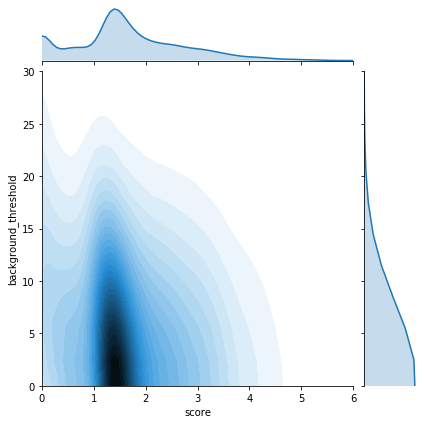

In [17]:
ax = sns.jointplot(x='score', y='background_threshold', data=df, kind='kde', xlim=(0, 6), ylim=((0, 30)), 
                   joint_kws={'n_levels': 30, 'shade': True, 'shade_lowest': False})
# ax.set_xlim((0, 50))
# ax.set_ylim((0, 6))

### Cluster number
Very similar distribution to background threshold

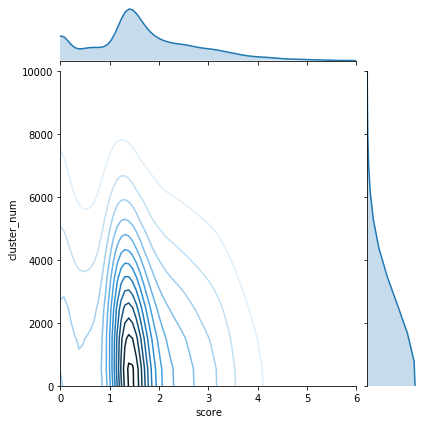

In [22]:
ax = sns.jointplot(x='score', y='cluster_num', data=df, kind='kde', xlim=(0, 6), ylim=((0, 10000)), 
                   joint_kws={'n_levels': 15, 'shade': False, 'shade_lowest': False})

In [58]:
low_cluster_num_df = df[df.cluster_num <= 300]
medium_cluster_num_df = df[(df.cluster_num <= 1500) & (df.cluster_num > 300)]
high_cluster_num_df = df[df.cluster_num > 1500]
low_cluster_num_df.shape[0], medium_cluster_num_df.shape[0], high_cluster_num_df.shape[0]

(7842, 649, 1109)

#### Small, medium and large number of clusters
Real images are defined by a "small" number of clusters. This plot shows that images with a medium and high number of clusters are mostly given scores close to 0, whereas images with small number of clusters are mostly given a score of 1-4

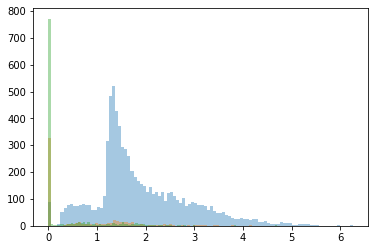

In [59]:
fig, ax1 = plt.subplots(1, 1)
sns.distplot(low_cluster_num_df.score.values, bins=100, hist=True, kde=False, rug=False, ax=ax1, label='[0-300] clusters')
sns.distplot(medium_cluster_num_df.score.values, bins=100, hist=True, kde=False, rug=False, ax=ax1, label='(300-1000] clusters')
sns.distplot(high_cluster_num_df.score.values, bins=100, hist=True, kde=False, rug=False, ax=ax1, label='(1000, 10000] clusters')

In [5]:
cluster_sizes_avg = np.empty((9600))
cluster_peak_intensities_avg = np.empty((9600))
cluster_num_intensities_avg = np.empty((9600))

for i in tqdm(range(len(df.index))):
    c_s = df.iloc[i,3]
    c_p_i = df.iloc[i,4]
    c_n_i = df.iloc[i,5]
    cluster_sizes_avg[i] = np.average(np.array(c_s))
    cluster_peak_intensities_avg[i] = np.average(np.array(c_p_i))
    cluster_num_intensities_avg[i] = np.average(np.array(c_n_i))

  0%|                                                                                         | 0/9600 [00:00<?, ?it/s]


TypeError: cannot perform reduce with flexible type

In [26]:
df_avg = df
df_avg['cluster_sizes_avg'] = cluster_sizes_avg
df_avg['cluster_peak_intensities_avg'] = cluster_peak_intensities_avg
df_avg['cluster_num_intensities_avg'] = cluster_num_intensities_avg
df_avg.head()

,score,background_threshold,cluster_num,cluster_sizes,cluster_peak_intensities,cluster_num_intensities,cluster_centers,cluster_sizes_avg,cluster_peak_intensities_avg,cluster_num_intensities_avg
id,,,,,,,,,,
1002900,2.631728,0,50,"[144, 38, 24, 16, 5, 39, 17, 18, 26, 11, 56, 1...","[6, 6, 2, 2, 1, 8, 2, 1, 3, 1, 3, 2, 255, 2, 6...","[6, 6, 2, 2, 1, 7, 2, 1, 3, 1, 3, 2, 71, 2, 6,...","[(3, 524), (44, 425), (55, 321), (66, 400), (9...",35.580000,14.920000,6.680000
1003620,1.560731,0,104,"[28, 17, 8, 11, 45, 4, 14, 71, 1, 7, 2, 18, 11...","[4, 2, 1, 2, 9, 1, 2, 16, 1, 1, 1, 3, 1, 1, 1,...","[4, 2, 1, 2, 8, 1, 2, 14, 1, 1, 1, 3, 1, 1, 1,...","[(19, 375), (53, 839), (56, 524), (84, 208), (...",28.134615,11.375000,5.692308
1005208,3.137059,1,71,"[53, 27, 42, 6, 3, 15, 19, 45, 73, 115, 119, 6...","[12, 4, 9, 2, 2, 2, 3, 4, 9, 68, 78, 2, 2, 2, ...","[10, 3, 8, 1, 1, 1, 2, 3, 8, 31, 34, 1, 1, 1, ...","[(3, 582), (0, 715), (14, 83), (19, 614), (51,...",34.169014,11.563380,5.605634
1005849,3.509851,2,49,"[1, 5, 61, 4, 80, 45, 68, 44, 10, 35, 28, 7, 3...","[3, 3, 12, 3, 69, 15, 12, 17, 3, 4, 5, 3, 3, 3...","[1, 1, 10, 1, 27, 8, 9, 13, 1, 2, 3, 1, 1, 1, ...","[(0, 906), (0, 949), (5, 508), (24, 591), (34,...",53.632653,22.612245,8.428571
1006237,1.371129,0,169,"[3, 92, 6, 138, 16, 12, 142, 6, 31, 1, 11, 3, ...","[1, 179, 1, 255, 2, 1, 5, 1, 5, 1, 1, 1, 3, 1,...","[1, 41, 1, 47, 2, 1, 5, 1, 5, 1, 1, 1, 3, 1, 2...","[(0, 604), (2, 736), (13, 155), (26, 601), (22...",20.526627,6.621302,3.284024


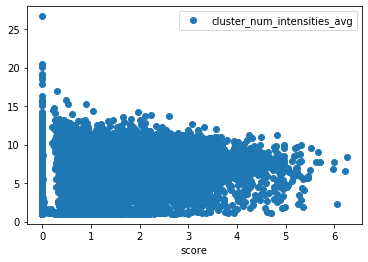

In [27]:
df.plot(x='score', y='cluster_num_intensities_avg', style='o')

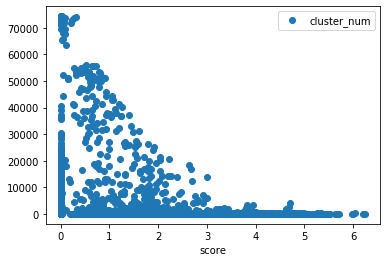

In [28]:
df.plot(x='score', y='cluster_num', style='o')

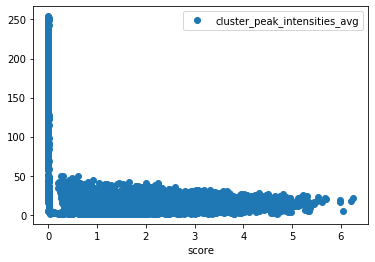

In [29]:
df.plot(x='score', y='cluster_peak_intensities_avg', style='o')

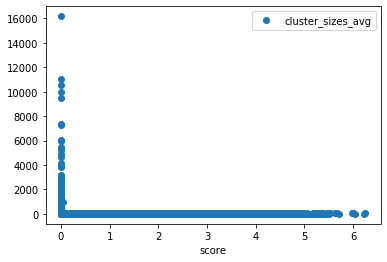

In [30]:
df.plot(x='score', y='cluster_sizes_avg', style='o')

In [31]:
scores = []
cluster_x = []
cluster_y = []

for i in tqdm(range(len(df.index))):
    score = df.iloc[i,0]
    cluster_num = df.iloc[i,2]
    cluster_centers = df.iloc[i,6]
    for j in range(cluster_num):
        scores.append(score)
        (x,y) = cluster_centers[j]
        cluster_x.append(x)
        cluster_y.append(y)

100%|█████████████████████████████████████████████████████████████████████████████| 9600/9600 [00:18<00:00, 513.32it/s]


In [32]:
scores_sample = []
cluster_x_samples = []
cluster_y_samples = []

for i in tqdm(range(0,len(scores), 100000)):
    scores_sample.append(scores[i])
    cluster_x_samples.append(cluster_x[i])
    cluster_y_samples.append(cluster_y[i])

np.array(scores_sample).shape

100%|████████████████████████████████████████████████████████████████████████████| 393/393 [00:00<00:00, 483958.15it/s]


(393,)

In [33]:
scores_avg = np.empty(len(df.index))
cluster_x_avg = np.empty(len(df.index))
cluster_y_avg = np.empty(len(df.index))

for i in tqdm(range(len(df.index))):
    scores_avg[i] = df.iloc[i,0]
    cluster_num = df.iloc[i,2]
    cluster_centers = df.iloc[i,6]
    temp_x = np.empty(cluster_num)
    temp_y = np.empty(cluster_num)
    for j in range(cluster_num):
        (x,y) = cluster_centers[j]
        temp_x[j] = x 
        temp_y[j] = y
    cluster_x_avg[i] = np.average(temp_x)
    cluster_y_avg[i] = np.average(temp_y)

 64%|█████████████████████████████████████████████████▋                           | 6188/9600 [00:10<00:06, 508.36it/s]D:\programs\anaconda3\envs\cil\lib\site-packages\numpy\lib\function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
D:\programs\anaconda3\envs\cil\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|█████████████████████████████████████████████████████████████████████████████| 9600/9600 [00:15<00:00, 617.47it/s]


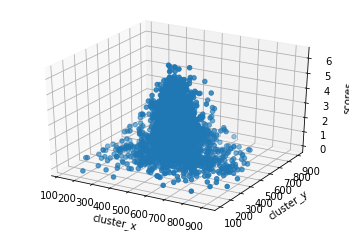

In [34]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.scatter(cluster_x_avg, cluster_y_avg, scores_avg)
ax.set_xlabel('cluster_x')
ax.set_ylabel('cluster_y')
ax.set_zlabel('scores')
plt.show()

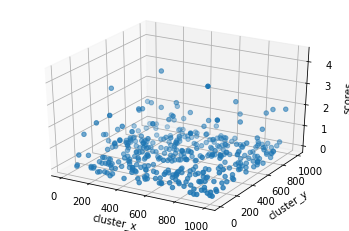

In [35]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.scatter(cluster_x_samples, cluster_y_samples, scores_sample)
ax.set_xlabel('cluster_x')
ax.set_ylabel('cluster_y')
ax.set_zlabel('scores')
plt.show()

In [36]:
# [cluster_num, cluster_num_intensities_avg, cluster_peak_intensities_avg, cluster_x_avg, cluster_y_avg]

train_X = np.empty((len(df.index),5))
train_y = scores_avg

for i in tqdm(range(len(df.index))):
    train_X[i,0] = df.iloc[i,2]
    train_X[i, 1] = cluster_num_intensities_avg[i]
    train_X[i, 2] = cluster_peak_intensities_avg[i]
    train_X[i, 3] = cluster_x_avg[i]
    train_X[i, 4] = cluster_y_avg[i]

100%|██████████████████████████████████████████████████████████████████████████| 9600/9600 [00:00<00:00, 121698.96it/s]


In [ ]:
cluster_sizes_avg = np.empty((df.shape[0]))
cluster_peak_intensities_avg = np.empty((df.shape[0]))
cluster_num_intensities_avg = np.empty((df.shape[0]))

for i in tqdm(range(len(df.index))):
    c_s = df.iloc[i,3]
    c_p_i = df.iloc[i,4]
    c_n_i = df.iloc[i,5]
    cluster_sizes_avg[i] = np.average(np.array(c_s))
    cluster_peak_intensities_avg[i] = np.average(np.array(c_p_i))
    cluster_num_intensities_avg[i] = np.average(np.array(c_n_i))

In [37]:
df_X = pd.DataFrame(columns=['cluster_num', 'cluster_num_intensities_avg', 'cluster_peak_intensities_avg', 'cluster_x_avg', 'cluster_y_avg'])
df_y = pd.DataFrame(columns=['score'])
df_X['cluster_num'] = train_X[:,0]
df_X['cluster_num_intensities_avg'] = train_X[:,1]
df_X['cluster_peak_intensities_avg'] = train_X[:,2]
df_X['cluster_x_avg'] = train_X[:,3]
df_X['cluster_y_avg'] = train_X[:,4]
df_y['score'] = scores_avg

df_X.to_csv('train_X.csv', index=False)
df_y.to_csv('train_y.csv', index=False)

**Preparing data for query**

In [60]:
test_X = extract_all_information_query(os.path.join('..', 'data','query'))

 92%|███████████████████████████████████████████████████████████████████████▊      | 1104/1200 [18:04<01:34,  1.02it/s]


KeyboardInterrupt: 

In [ ]:
test_df = to_df_query(test_X)
test_df.to_csv('test_df.csv')
test_df.head()

### Pre-compute and save the test features

In [72]:
def get_features(test_df):
    cluster_sizes_avg = np.empty(len(test_df.index))
    cluster_peak_intensities_avg = np.empty(len(test_df.index))
    cluster_num_intensities_avg = np.empty(len(test_df.index))

    cluster_x_avg = np.empty(len(test_df.index))
    cluster_y_avg = np.empty(len(test_df.index))

    for i in tqdm(range(len(test_df.index))):
        c_s = test_df.iloc[i,2]
        c_p_i = test_df.iloc[i,3]
        c_n_i = test_df.iloc[i,4]
        cluster_sizes_avg[i] = np.average(np.array(c_s))
        cluster_peak_intensities_avg[i] = np.average(np.array(c_p_i))
        cluster_num_intensities_avg[i] = np.average(np.array(c_n_i))
        cluster_num = test_df.iloc[i,1]
        cluster_centers = test_df.iloc[i,5]
        temp_x = np.empty(cluster_num)
        temp_y = np.empty(cluster_num)
        for j in range(cluster_num):
            (x,y) = cluster_centers[j]
            temp_x[j] = x 
            temp_y[j] = y
        cluster_x_avg[i] = np.average(temp_x)
        cluster_y_avg[i] = np.average(temp_y)

    # [cluster_num, cluster_num_intensities_avg, cluster_peak_intensities_avg, cluster_x_avg, cluster_y_avg]
    eval_X = np.empty((len(test_df.index),6))

    for i in tqdm(range(len(test_df.index))):
        eval_X[i,0] = test_df.iloc[i,1]
        eval_X[i, 1] = cluster_num_intensities_avg[i]
        eval_X[i, 2] = cluster_peak_intensities_avg[i]
        eval_X[i, 3] = cluster_x_avg[i]
        eval_X[i, 4] = cluster_y_avg[i]
        eval_X[i, 5] = test_df.iloc[i, 0]
        
    df_X = pd.DataFrame(columns=['cluster_num', 'cluster_num_intensities_avg', 'cluster_peak_intensities_avg', 'cluster_x_avg', 'cluster_y_avg'])
    df_X['cluster_num'] = eval_X[:,0]
    df_X['cluster_num_intensities_avg'] = eval_X[:,1]
    df_X['cluster_peak_intensities_avg'] = eval_X[:,2]
    df_X['cluster_x_avg'] = eval_X[:,3]
    df_X['cluster_y_avg'] = eval_X[:,4]
    df_X['background_threshold'] = eval_X[:, 5]
        
    return df_X

In [61]:
test_df = pd.read_csv('test_df.csv', index='id')
# pd saves lists as strings, so we need to convert them to lists manually
test_df.cluster_sizes = test_df.cluster_sizes.swifter.apply(ast.literal_eval)
test_df.cluster_centers = test_df.cluster_centers.swifter.apply(ast.literal_eval)
test_df.cluster_peak_intensities = test_df.cluster_peak_intensities.swifter.apply(ast.literal_eval)
test_df.cluster_num_intensities = test_df.cluster_num_intensities.swifter.apply(ast.literal_eval)

assert type(test_df.cluster_sizes.tolist()[0]) == list

In [70]:
# del test_df['Unnamed: 0']
test_df.head(5)

,background_threshold,cluster_num,cluster_sizes,cluster_peak_intensities,cluster_num_intensities,cluster_centers
0,0,94,"[6, 20, 109, 1, 8, 2, 4, 3, 57, 8, 32, 4, 5, 2...","[1, 3, 111, 1, 1, 1, 1, 1, 22, 1, 4, 1, 1, 1, ...","[1, 3, 36, 1, 1, 1, 1, 1, 17, 1, 4, 1, 1, 1, 2...","[(1, 39), (5, 295), (30, 107), (25, 286), (46,..."
1,187,20943,"[69, 1, 70, 4, 381, 111, 73, 70, 1, 16, 41, 26...","[254, 191, 254, 242, 254, 251, 251, 250, 219, ...","[33, 1, 36, 4, 62, 41, 37, 34, 1, 14, 22, 18, ...","[(1, 10), (0, 18), (2, 25), (1, 41), (17, 56),..."
2,0,64,"[4, 82, 11, 7, 2, 40, 102, 160, 3, 6, 7, 54, 3...","[1, 4, 2, 5, 1, 5, 85, 251, 1, 2, 1, 29, 1, 1,...","[1, 4, 2, 4, 1, 5, 34, 54, 1, 2, 1, 17, 1, 1, ...","[(0, 906), (19, 900), (61, 728), (130, 428), (..."
3,3,50,"[197, 9, 19, 59, 5, 10, 45, 18, 35, 84, 19, 20...","[26, 4, 7, 7, 4, 4, 19, 4, 13, 9, 6, 46, 49, 4...","[19, 1, 4, 4, 1, 1, 12, 1, 9, 6, 3, 30, 23, 1,...","[(17, 159), (22, 965), (50, 794), (101, 387), ..."
4,2,57,"[12, 16, 8, 120, 11, 14, 8, 25, 8, 5, 5, 7, 85...","[4, 3, 3, 5, 3, 3, 3, 6, 3, 3, 3, 3, 69, 255, ...","[2, 1, 1, 3, 1, 1, 1, 4, 1, 1, 1, 1, 28, 89, 1...","[(7, 567), (10, 67), (18, 448), (37, 14), (36,..."


In [73]:
test_features_df = get_features(test_df)
test_features_df.to_csv('test_df.csv', index=False)

100%|███████████████████████████████████████████████████████████████████████████| 1200/1200 [00:00<00:00, 25353.31it/s]
